In [48]:
import os
import json
import pymongo
import statistics
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import ScalarFormatter

params = {'text.usetex' : True,
          'font.size' : 14,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params) 

MONGO_HOST = "localhost"
MONGO_PORT = 27017

mongo_connection = pymongo.MongoClient("mongodb://"+MONGO_HOST+":"+str(MONGO_PORT), maxPoolSize=None)

In [12]:
eth_arb = list(mongo_connection["arbitrum"]["cross_layer_sandwich_simulation"].find())
print("Number of successful simulations on Arbitrum:", len(eth_arb))

eth_opt = list(mongo_connection["optimism"]["cross_layer_sandwich_simulation"].find())
print("Number of successful simulations on Optimism:", len(eth_opt))

Number of successful simulations on Arbitrum: 71956
Number of successful simulations on Optimism: 93399


In [13]:
def get_price_from_timestamp(timestamp, prices):
    timestamp *= 1000
    one_eth_to_usd = prices[-1][1]
    for index, _ in enumerate(prices):
        if index < len(prices)-1:
            if prices[index][0] <= timestamp and timestamp <= prices[index+1][0]:
                return prices[index][1]
    return one_eth_to_usd

In [35]:
def get_prices():
    prices = dict()
    if os.path.exists("price_eth_to_usd.json"):
        with open("price_eth_to_usd.json", "r") as f:
            prices = json.load(f)
    return prices

In [38]:
prices = get_prices()
l2_avg = 24869307646657

In [39]:
budgets_arb = {
    "1000":[list(),list(),list()],
    "10000":[list(),list(),list()],
    "100000":[list(),list(),list()],
    "1000000":[list(),list(),list()],
    "1000000000000000.0":[list(),list(),list()],
}

for x in eth_arb:
    if "l2_timestamp" not in x:
        continue
    trx_fee_to_usd =  x['usd_trx_fee'] 
    eth_to_usd_price = get_price_from_timestamp(x["l2_timestamp"], prices["eth_to_usd"])
    trx_l2_fee_to_usd = (l2_avg * eth_to_usd_price / (10**18))
    
    for result in x["budget_findings"]:
        
        result['s1_usd'] = ( (float( result['profit_simple_backrun_usd']) - (2 *trx_fee_to_usd) )) 
        result['s2_usd'] = ( (float( result['profit_simple_backrun_usd']) - trx_fee_to_usd -  trx_l2_fee_to_usd  ))
        result['s3_usd'] = ( (float( result['profit_simple_backrun_usd']) - (2*trx_l2_fee_to_usd  )))
                
        result['s1_usd'] = result['s1_usd'] if result['s1_usd'] > 0 else 0
        result['s2_usd'] = result['s2_usd'] if result['s2_usd'] > 0 else 0
        result['s3_usd'] = result['s3_usd'] if result['s3_usd'] > 0 else 0
        if result['s1_usd'] > 0:
            budgets_arb[result['budget_usd']][0].append(x)
        if result['s2_usd'] > 0:
            budgets_arb[result['budget_usd']][1].append(x)
        if result['s3_usd'] > 0:
            budgets_arb[result['budget_usd']][2].append(x)
            
budgets_opt = {
    "1000":[list(),list(),list()],
    "10000":[list(),list(),list()],
    "100000":[list(),list(),list()],
    "1000000":[list(),list(),list()],
    "1000000000000000.0":[list(),list(),list()],
}

for x in eth_opt: 
    if "l2_timestamp" not in x:
        continue
    trx_fee_to_usd =  x['usd_trx_fee']  
    eth_to_usd_price = get_price_from_timestamp(x["l2_timestamp"], prices["eth_to_usd"])
    trx_l2_fee_to_usd = (l2_avg * eth_to_usd_price / (10**18))
    
    for result in x["budget_findings"]:
        
        result['s1_usd'] = ( (float( result['profit_simple_backrun_usd']) - (2 *trx_fee_to_usd) )) 
        result['s2_usd'] = ( (float( result['profit_simple_backrun_usd']) - trx_fee_to_usd -  trx_l2_fee_to_usd  ))
        result['s3_usd'] = ( (float( result['profit_simple_backrun_usd']) - (2*trx_l2_fee_to_usd  )))
                
        result['s1_usd'] = result['s1_usd'] if result['s1_usd'] > 0 else 0
        result['s2_usd'] = result['s2_usd'] if result['s2_usd'] > 0 else 0
        result['s3_usd'] = result['s3_usd'] if result['s3_usd'] > 0 else 0
        if result['s1_usd'] > 0:
            budgets_opt[result['budget_usd']][0].append(x)
        if result['s2_usd'] > 0:
            budgets_opt[result['budget_usd']][1].append(x)
        if result['s3_usd'] > 0:
            budgets_opt[result['budget_usd']][2].append(x)

In [40]:
print("Profit Arbitrum with different Budgets: ")
print()
print ("{:>22} {:>20}{:>20}{:>20} ".format('Budget','S1','S2','S3',))
print ("{:>20} $ {:>20}{:>20}{:>20} ".format("1000",   len(budgets_arb["1000"][0]),len(budgets_arb["1000"][1]),len(budgets_arb["1000"][2])  ))
print ("{:>20} $ {:>20}{:>20}{:>20} ".format("10000",  len(budgets_arb["10000"][0]),len(budgets_arb["10000"][1]),len(budgets_arb["10000"][2])  ))
print ("{:>20} $ {:>20}{:>20}{:>20} ".format("100000", len(budgets_arb["100000"][0]),len(budgets_arb["100000"][1]) ,len(budgets_arb["100000"][2]) ))
print ("{:>20} $ {:>20}{:>20}{:>20} ".format("1000000",len(budgets_arb["1000000"][0]),len(budgets_arb["1000000"][1]),len(budgets_arb["1000000"][2]) ))
print ("{:>20} $ {:>20}{:>20}{:>20} ".format("Infinit",len(budgets_arb["1000000000000000.0"][0]),len(budgets_arb["1000000000000000.0"][1]) ,len(budgets_arb["1000000000000000.0"][2] ))  )  
print()
print()
print("Profit Optimism with different Budgets: ")
print()
print ("{:>22} {:>20}{:>20}{:>20} ".format('Budget','S1','S2','S3',))
print ("{:>20} $ {:>20}{:>20}{:>20} ".format("1000",   len(budgets_opt["1000"][0]),len(budgets_opt["1000"][1]),len(budgets_opt["1000"][2])  ))
print ("{:>20} $ {:>20}{:>20}{:>20} ".format("10000",  len(budgets_opt["10000"][0]),len(budgets_opt["10000"][1]),len(budgets_opt["10000"][2])  ))
print ("{:>20} $ {:>20}{:>20}{:>20} ".format("100000", len(budgets_opt["100000"][0]),len(budgets_opt["100000"][1]) ,len(budgets_opt["100000"][2]) ))
print ("{:>20} $ {:>20}{:>20}{:>20} ".format("1000000",len(budgets_opt["1000000"][0]),len(budgets_opt["1000000"][1]),len(budgets_opt["1000000"][2]) ))
print ("{:>20} $ {:>20}{:>20}{:>20} ".format("Infinit",len(budgets_opt["1000000000000000.0"][0]),len(budgets_opt["1000000000000000.0"][1]) ,len(budgets_opt["1000000000000000.0"][2] ))  )  

Profit Arbitrum with different Budgets: 

                Budget                   S1                  S2                  S3 
                1000 $                   10                  17                 216 
               10000 $                   86                 126                 254 
              100000 $                  220                 237                 277 
             1000000 $                  289                 295                 320 
             Infinit $                  314                 322                 345 


Profit Optimism with different Budgets: 

                Budget                   S1                  S2                  S3 
                1000 $                    7                  29                 709 
               10000 $                  196                 302                 815 
              100000 $                  534                 643                 847 
             1000000 $                  773                 845 

In [41]:
budgets_profits_arb = {
    "1000":[0,0,0],
    "10000":[0,0,0],
    "100000":[0,0,0],
    "1000000":[0,0,0],
    "1000000000000000.0":[0,0,0],
}
budgets_profits_opt = {
    "1000":[0,0,0],
    "10000":[0,0,0],
    "100000":[0,0,0],
    "1000000":[0,0,0],
    "1000000000000000.0":[0,0,0],
}
budget_usd = ["1000","10000","100000","1000000","1000000000000000.0"]

for i in range(5):
    [s1_list_arb,s2_list_arb,s3_list_arb] = budgets_arb[budget_usd[i]]
    [s1_list_opt,s2_list_opt,s3_list_opt] = budgets_opt[budget_usd[i]]
    for entry in s1_list_arb:
        budgets_profits_arb[budget_usd[i]][0] += float(entry['budget_findings'][i]['s1_usd'])
    for entry in s2_list_arb:
        budgets_profits_arb[budget_usd[i]][1] += float(entry['budget_findings'][i]['s2_usd'])   
    for entry in s3_list_arb:
        budgets_profits_arb[budget_usd[i]][2] += float(entry['budget_findings'][i]['s3_usd'])    
          
    for entry in s1_list_opt:
        budgets_profits_opt[budget_usd[i]][0] += float(entry['budget_findings'][i]['s1_usd'])
    for entry in s2_list_opt:
        budgets_profits_opt[budget_usd[i]][1] += float(entry['budget_findings'][i]['s2_usd'])   
    for entry in s3_list_opt:
        budgets_profits_opt[budget_usd[i]][2] += float(entry['budget_findings'][i]['s3_usd'])          

In [42]:

print("Profit Arbitrum with infinit Money ")
print()
print ("{:>22}   {:>20}   {:>20}   {:>20}".format('Budget','S1','S2','S3'))
print ("{:>20} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format("1000",   budgets_profits_arb["1000"][0],                budgets_profits_arb["1000"][1], budgets_profits_arb["1000"][2]  ))
print ("{:>20} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format("10000",  budgets_profits_arb["10000"][0],               budgets_profits_arb["10000"][1], budgets_profits_arb["10000"][2] ))
print ("{:>20} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format("100000", budgets_profits_arb["100000"][0],              budgets_profits_arb["100000"][1], budgets_profits_arb["100000"][2] ))
print ("{:>20} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format("1000000",budgets_profits_arb["1000000"][0],             budgets_profits_arb["1000000"][1], budgets_profits_arb["1000000"][2] ))
print ("{:>20} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format("Infinit",budgets_profits_arb["1000000000000000.0"][0],  budgets_profits_arb["1000000000000000.0"][1], budgets_profits_arb["1000000000000000.0"][2]  ))    
print()
print()
print("Profit Optimism with infinit Money ")
print()
print ("{:>22}   {:>20}   {:>20}   {:>20}".format('Budget','S1','S2','S3'))
print ("{:>20} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format("1000",   budgets_profits_opt["1000"][0],                budgets_profits_opt["1000"][1], budgets_profits_opt["1000"][2]  ))
print ("{:>20} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format("10000",  budgets_profits_opt["10000"][0],               budgets_profits_opt["10000"][1], budgets_profits_opt["10000"][2] ))
print ("{:>20} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format("100000", budgets_profits_opt["100000"][0],              budgets_profits_opt["100000"][1], budgets_profits_opt["100000"][2] ))
print ("{:>20} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format("1000000",budgets_profits_opt["1000000"][0],             budgets_profits_opt["1000000"][1], budgets_profits_opt["1000000"][2] ))
print ("{:>20} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format("Infinit",budgets_profits_opt["1000000000000000.0"][0],  budgets_profits_opt["1000000000000000.0"][1], budgets_profits_opt["1000000000000000.0"][2]  ))    

Profit Arbitrum with infinit Money 

                Budget                     S1                     S2                     S3
                1000 $                38.93 $                59.93 $               237.47 $
               10000 $             1,235.10 $             1,606.38 $             2,410.52 $
              100000 $            14,631.47 $            15,775.96 $            17,108.52 $
             1000000 $           129,656.26 $           131,257.43 $           132,926.89 $
             Infinit $         1,224,200.05 $         1,225,968.21 $         1,227,808.79 $


Profit Optimism with infinit Money 

                Budget                     S1                     S2                     S3
                1000 $               226.35 $               295.37 $             1,213.84 $
               10000 $             4,966.80 $             6,688.07 $            11,369.12 $
              100000 $            68,991.44 $            75,679.86 $            86,369.52 $
    

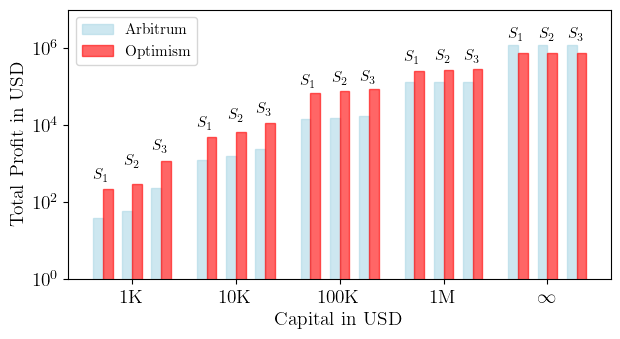

In [47]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 3.5)

capital = ['1K', '10K', '100K', '1M', r'$\infty$']

data = ((budgets_profits_arb["1000"][0], budgets_profits_opt["1000"][0], 0, budgets_profits_arb["1000"][1], budgets_profits_opt["1000"][1], 0, budgets_profits_arb["1000"][2], budgets_profits_opt["1000"][2]), 
        (budgets_profits_arb["10000"][0], budgets_profits_opt["10000"][0], 0, budgets_profits_arb["10000"][1], budgets_profits_opt["10000"][1], 0, budgets_profits_arb["10000"][2], budgets_profits_opt["10000"][2]),  
        (budgets_profits_arb["100000"][0], budgets_profits_opt["100000"][0], 0, budgets_profits_arb["100000"][1], budgets_profits_opt["100000"][1], 0, budgets_profits_arb["100000"][2], budgets_profits_opt["100000"][2]), 
        (budgets_profits_arb["1000000"][0], budgets_profits_opt["1000000"][0], 0, budgets_profits_arb["1000000"][1], budgets_profits_opt["1000000"][1], 0, budgets_profits_arb["1000000"][2], budgets_profits_opt["1000000"][2]), 
        (budgets_profits_arb["1000000000000000.0"][0], budgets_profits_opt["1000000000000000.0"][0], 0, budgets_profits_arb["1000000000000000.0"][1], budgets_profits_opt["1000000000000000.0"][1], 0, budgets_profits_arb["1000000000000000.0"][2], budgets_profits_opt["1000000000000000.0"][2])) 

dim = len(data[0])
w = 0.75
dimw = w / dim

x = np.arange(len(data))
for i in range(len(data[0])):
    y = [d[i] for d in data]
    if i in [0, 3, 6]:
        b = ax.bar(x + i * dimw, y, dimw, bottom=0.001, edgecolor='LightBlue', color='LightBlue', alpha=0.6)
    if i in [1, 4, 7]:
        b = ax.bar(x + i * dimw, y, dimw, bottom=0.001, edgecolor='red', color='red', alpha=0.6)

ax.set_xticks(x + dimw / 2 * dim - dimw / 2, labels=map(str, capital))

ax.text(-0.05, 400, r'$S_1$', fontsize=11)
ax.text(0.25, 900, r'$S_2$', fontsize=11)
ax.text(0.525, 2200, r'$S_3$', fontsize=11)

ax.text(0.95, 9000, r'$S_1$', fontsize=11)
ax.text(1.25, 14000, r'$S_2$', fontsize=11)
ax.text(1.525, 20000, r'$S_3$', fontsize=11)

ax.text(1.95, 110000, r'$S_1$', fontsize=11)
ax.text(2.25, 130000, r'$S_2$', fontsize=11)
ax.text(2.525, 140000, r'$S_3$', fontsize=11)

ax.text(2.95, 450000, r'$S_1$', fontsize=11)
ax.text(3.25, 480000, r'$S_2$', fontsize=11)
ax.text(3.525, 480000, r'$S_3$', fontsize=11)

ax.text(3.95, 1800000, r'$S_1$', fontsize=11)
ax.text(4.25, 1800000, r'$S_2$', fontsize=11)
ax.text(4.525, 1800000, r'$S_3$', fontsize=11)

ax.set_yscale('log')

ax.set_ylabel('Total Profit in USD')
ax.set_xlabel('Capital in USD')

ax.set_ylim(bottom=1, top=10000000)

legend = ax.legend(["Arbitrum", "Optimism"], loc='upper left', frameon=True, ncol=1, prop={"size": 11})

fig.savefig('figure_10.png', bbox_inches='tight', facecolor='white', transparent=True, dpi=1000)

In [64]:
budgets_usd = ["1000","10000","100000","1000000","1000000000000000.0"]

budgets_statistics_arb = {
    "1000":                 [[],[],[]],
    "10000":                [[],[],[]],
    "100000":               [[],[],[]],
    "1000000":              [[],[],[]],
    "1000000000000000.0":   [[],[],[]],
}

budgets_mean_arb = {
    "1000":                 [[],[],[]],
    "10000":                [[],[],[]],
    "100000":               [[],[],[]],
    "1000000":              [[],[],[]],
    "1000000000000000.0":   [[],[],[]],
}
budgets_median_arb = {
    "1000":                 [[],[],[]],
    "10000":                [[],[],[]],
    "100000":               [[],[],[]],
    "1000000":              [[],[],[]],
    "1000000000000000.0":   [[],[],[]],
}
budgets_max_arb = {
    "1000":                 [[],[],[]],
    "10000":                [[],[],[]],
    "100000":               [[],[],[]],
    "1000000":              [[],[],[]],
    "1000000000000000.0":   [[],[],[]],
}
budgets_min_arb = {
    "1000":                 [[],[],[]],
    "10000":                [[],[],[]],
    "100000":               [[],[],[]],
    "1000000":              [[],[],[]],
    "1000000000000000.0":   [[],[],[]],
}
#_arb
#_opt
budgets_statistics_opt = {
    "1000":                 [[],[],[]],
    "10000":                [[],[],[]],
    "100000":               [[],[],[]],
    "1000000":              [[],[],[]],
    "1000000000000000.0":   [[],[],[]],
}

budgets_mean_opt = {
    "1000":                 [[],[],[]],
    "10000":                [[],[],[]],
    "100000":               [[],[],[]],
    "1000000":              [[],[],[]],
    "1000000000000000.0":   [[],[],[]],
}
budgets_median_opt = {
    "1000":                 [[],[],[]],
    "10000":                [[],[],[]],
    "100000":               [[],[],[]],
    "1000000":              [[],[],[]],
    "1000000000000000.0":   [[],[],[]],
}
budgets_max_opt = {
    "1000":                 [[],[],[]],
    "10000":                [[],[],[]],
    "100000":               [[],[],[]],
    "1000000":              [[],[],[]],
    "1000000000000000.0":   [[],[],[]],
}
budgets_min_opt = {
    "1000":                 [[],[],[]],
    "10000":                [[],[],[]],
    "100000":               [[],[],[]],
    "1000000":              [[],[],[]],
    "1000000000000000.0":   [[],[],[]],
}

for index,budget_usd in enumerate(budgets_usd):
    [s1_arb,s2_arb,s3_arb] = budgets_arb[budget_usd]
    budgets_statistics_arb[budget_usd][0] = [x["budget_findings"][index]["s1_usd"] for x in s1_arb]
    budgets_statistics_arb[budget_usd][1] = [x["budget_findings"][index]["s2_usd"] for x in s2_arb]
    budgets_statistics_arb[budget_usd][2] = [x["budget_findings"][index]["s3_usd"] for x in s3_arb]
    budgets_median_arb[budget_usd][0]       = statistics.median(budgets_statistics_arb[budget_usd][0])
    budgets_median_arb[budget_usd][1]       = statistics.median(budgets_statistics_arb[budget_usd][1])
    budgets_median_arb[budget_usd][2]       = statistics.median(budgets_statistics_arb[budget_usd][2])
    budgets_mean_arb[budget_usd][0]         = statistics.mean(budgets_statistics_arb[budget_usd][0])
    budgets_mean_arb[budget_usd][1]         = statistics.mean(budgets_statistics_arb[budget_usd][1])
    budgets_mean_arb[budget_usd][2]         = statistics.mean(budgets_statistics_arb[budget_usd][2])
    budgets_max_arb[budget_usd][0]          = max(budgets_statistics_arb[budget_usd][0])
    budgets_max_arb[budget_usd][1]          = max(budgets_statistics_arb[budget_usd][1])
    budgets_max_arb[budget_usd][2]          = max(budgets_statistics_arb[budget_usd][2])
    budgets_min_arb[budget_usd][0]          = min(budgets_statistics_arb[budget_usd][0])
    budgets_min_arb[budget_usd][1]          = min(budgets_statistics_arb[budget_usd][1])
    budgets_min_arb[budget_usd][2]          = min(budgets_statistics_arb[budget_usd][2])
    
    [s1_opt,s2_opt,s3_opt] = budgets_opt[budget_usd]
    budgets_statistics_opt[budget_usd][0] = [x["budget_findings"][index]["s1_usd"] for x in s1_opt]
    budgets_statistics_opt[budget_usd][1] = [x["budget_findings"][index]["s2_usd"] for x in s2_opt]
    budgets_statistics_opt[budget_usd][2] = [x["budget_findings"][index]["s3_usd"] for x in s3_opt]
    budgets_median_opt[budget_usd][0]       = statistics.median(budgets_statistics_opt[budget_usd][0])
    budgets_median_opt[budget_usd][1]       = statistics.median(budgets_statistics_opt[budget_usd][1])
    budgets_median_opt[budget_usd][2]       = statistics.median(budgets_statistics_opt[budget_usd][2])
    budgets_mean_opt[budget_usd][0]         = statistics.mean(budgets_statistics_opt[budget_usd][0])
    budgets_mean_opt[budget_usd][1]         = statistics.mean(budgets_statistics_opt[budget_usd][1])
    budgets_mean_opt[budget_usd][2]         = statistics.mean(budgets_statistics_opt[budget_usd][2])
    budgets_max_opt[budget_usd][0]          = max(budgets_statistics_opt[budget_usd][0])
    budgets_max_opt[budget_usd][1]          = max(budgets_statistics_opt[budget_usd][1])
    budgets_max_opt[budget_usd][2]          = max(budgets_statistics_opt[budget_usd][2])
    budgets_min_opt[budget_usd][0]          = min(budgets_statistics_opt[budget_usd][0])
    budgets_min_opt[budget_usd][1]          = min(budgets_statistics_opt[budget_usd][1])
    budgets_min_opt[budget_usd][2]          = min(budgets_statistics_opt[budget_usd][2])

print ("Attack Strategy S1 Arbitrum")
print ()
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_profits_arb["1000"][0],budgets_profits_arb["10000"][0],budgets_profits_arb["100000"][0],budgets_profits_arb["1000000"][0],budgets_profits_arb["1000000000000000.0"][0]))
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_max_arb["1000"][0],budgets_max_arb["10000"][0],budgets_max_arb["100000"][0],budgets_max_arb["1000000"][0],budgets_max_arb["1000000000000000.0"][0]))
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_mean_arb["1000"][0],budgets_mean_arb["10000"][0],budgets_mean_arb["100000"][0],budgets_mean_arb["1000000"][0],budgets_mean_arb["1000000000000000.0"][0]))
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_median_arb["1000"][0],budgets_median_arb["10000"][0],budgets_median_arb["100000"][0],budgets_median_arb["1000000"][0],budgets_median_arb["1000000000000000.0"][0]))
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_min_arb["1000"][0],budgets_min_arb["10000"][0],budgets_min_arb["100000"][0],budgets_min_arb["1000000"][0],budgets_min_arb["1000000000000000.0"][0]))
print ()
print ("Attack Strategy S2 Arbitrum")
print ()
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_profits_arb["1000"][1],budgets_profits_arb["10000"][1],budgets_profits_arb["100000"][1],budgets_profits_arb["1000000"][1],budgets_profits_arb["1000000000000000.0"][1]))
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_max_arb["1000"][1],budgets_max_arb["10000"][1],budgets_max_arb["100000"][1],budgets_max_arb["1000000"][1],budgets_max_arb["1000000000000000.0"][1]))
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_mean_arb["1000"][1],budgets_mean_arb["10000"][1],budgets_mean_arb["100000"][1],budgets_mean_arb["1000000"][1],budgets_mean_arb["1000000000000000.0"][1]))
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_median_arb["1000"][1],budgets_median_arb["10000"][1],budgets_median_arb["100000"][1],budgets_median_arb["1000000"][1],budgets_median_arb["1000000000000000.0"][1]))
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_min_arb["1000"][1],budgets_min_arb["10000"][1],budgets_min_arb["100000"][1],budgets_min_arb["1000000"][1],budgets_min_arb["1000000000000000.0"][1]))
print ()
print ("Attack Strategy S3 Arbitrum")
print ()
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_profits_arb["1000"][2],budgets_profits_arb["10000"][2],budgets_profits_arb["100000"][2],budgets_profits_arb["1000000"][2],budgets_profits_arb["1000000000000000.0"][2]))
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_max_arb["1000"][2],budgets_max_arb["10000"][2],budgets_max_arb["100000"][2],budgets_max_arb["1000000"][2],budgets_max_arb["1000000000000000.0"][2]))
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_mean_arb["1000"][2],budgets_mean_arb["10000"][2],budgets_mean_arb["100000"][2],budgets_mean_arb["1000000"][2],budgets_mean_arb["1000000000000000.0"][2]))
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_median_arb["1000"][2],budgets_median_arb["10000"][2],budgets_median_arb["100000"][2],budgets_median_arb["1000000"][2],budgets_median_arb["1000000000000000.0"][2]))
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_min_arb["1000"][2],budgets_min_arb["10000"][2],budgets_min_arb["100000"][2],budgets_min_arb["1000000"][2],budgets_min_arb["1000000000000000.0"][2]))
print ()
print ()
print ()
print ("Attack Strategy S1 Optimism")
print ()
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_profits_opt["1000"][0],budgets_profits_opt["10000"][0],budgets_profits_opt["100000"][0],budgets_profits_opt["1000000"][0],budgets_profits_opt["1000000000000000.0"][0]))
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_max_opt["1000"][0],budgets_max_opt["10000"][0],budgets_max_opt["100000"][0],budgets_max_opt["1000000"][0],budgets_max_opt["1000000000000000.0"][0]))
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_mean_opt["1000"][0],budgets_mean_opt["10000"][0],budgets_mean_opt["100000"][0],budgets_mean_opt["1000000"][0],budgets_mean_opt["1000000000000000.0"][0]))
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_median_opt["1000"][0],budgets_median_opt["10000"][0],budgets_median_opt["100000"][0],budgets_median_opt["1000000"][0],budgets_median_opt["1000000000000000.0"][0]))
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_min_opt["1000"][0],budgets_min_opt["10000"][0],budgets_min_opt["100000"][0],budgets_min_opt["1000000"][0],budgets_min_opt["1000000000000000.0"][0]))
print ()
print ("Attack Strategy S2 Optimism")
print ()
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_profits_opt["1000"][1],budgets_profits_opt["10000"][1],budgets_profits_opt["100000"][1],budgets_profits_opt["1000000"][1],budgets_profits_opt["1000000000000000.0"][1]))
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_max_opt["1000"][1],budgets_max_opt["10000"][1],budgets_max_opt["100000"][1],budgets_max_opt["1000000"][1],budgets_max_opt["1000000000000000.0"][1]))
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_mean_opt["1000"][1],budgets_mean_opt["10000"][1],budgets_mean_opt["100000"][1],budgets_mean_opt["1000000"][1],budgets_mean_opt["1000000000000000.0"][1]))
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_median_opt["1000"][1],budgets_median_opt["10000"][1],budgets_median_opt["100000"][1],budgets_median_opt["1000000"][1],budgets_median_opt["1000000000000000.0"][1]))
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_min_opt["1000"][1],budgets_min_opt["10000"][1],budgets_min_opt["100000"][1],budgets_min_opt["1000000"][1],budgets_min_opt["1000000000000000.0"][1]))
print ()
print ("Attack Strategy S3 Optimism")
print ()
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_profits_opt["1000"][2],budgets_profits_opt["10000"][2],budgets_profits_opt["100000"][2],budgets_profits_opt["1000000"][2],budgets_profits_opt["1000000000000000.0"][2]))
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_max_opt["1000"][2],budgets_max_opt["10000"][2],budgets_max_opt["100000"][2],budgets_max_opt["1000000"][2],budgets_max_opt["1000000000000000.0"][2]))
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_mean_opt["1000"][2],budgets_mean_opt["10000"][2],budgets_mean_opt["100000"][2],budgets_mean_opt["1000000"][2],budgets_mean_opt["1000000000000000.0"][2]))
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_median_opt["1000"][2],budgets_median_opt["10000"][2],budgets_median_opt["100000"][2],budgets_median_opt["1000000"][2],budgets_median_opt["1000000000000000.0"][2]))
print ("{:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $ {:>20,.2f} $".format(budgets_min_opt["1000"][2],budgets_min_opt["10000"][2],budgets_min_opt["100000"][2],budgets_min_opt["1000000"][2],budgets_min_opt["1000000000000000.0"][2]))


Attack Strategy S1 Arbitrum

               38.93 $             1,235.10 $            14,631.47 $           129,656.26 $         1,224,200.05 $
               24.39 $               175.71 $             1,310.81 $            35,570.85 $           785,862.73 $
                3.89 $                14.36 $                66.51 $               448.64 $             3,898.73 $
                0.71 $                 7.07 $                33.27 $                88.44 $               106.07 $
                0.00 $                 0.00 $                 0.00 $                 0.00 $                 0.00 $

Attack Strategy S2 Arbitrum

               59.93 $             1,606.38 $            15,775.96 $           131,257.43 $         1,225,968.21 $
               27.20 $               178.52 $             1,312.94 $            35,576.04 $           785,866.70 $
                3.53 $                12.75 $                66.57 $               444.94 $             3,807.35 $
                1.38 